In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.lorenz96 import Lorenz96Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## Model

Toy continuous in time and discrete in space one-dimensional model of atmospheric dynamics on a latitude circle due to Lorenz [1]. For specific combinations of the magnitude of a forcing parameter $f$ and number of spatial grid points $N$ the dynamics exhibit spatio-temporal chaos. The model is governed by a system of ODEs defining the dynamics of a state variable at $N$ equally spaced grid-points $s_j = j \Delta$, $\Delta = \frac{L}{N}$ on a circular spatial domain

\begin{align}
  \frac{\mathrm{d} z_j}{\mathrm{d} t} = -\frac{z_{j\ominus 1} z_{j\oplus 1} - z_{j\ominus 2} z_{j\ominus 1}}{3 \Delta} - z_j + f
  \quad \forall j \in \{1 \dots N\}
\end{align}

with $\oplus$ and $\ominus$ indicating addition / subtraction modulo $N$ respectively.

Here we use $\Delta = \frac{1}{3}$, $N = 40$, $f= 8$ and an implicit midpoint integrator for the time stepping with step size $dt = 0.005$. Zero-mean Gaussian noise is added at every 20<sup>th</sup> timestep with standard deviation $\sigma_z = 0.1$ and the system is observed every 20<sup>th</sup> timestep at every second grid point with Gaussian observation noise of standard deviation $\sigma_x = 1$.

### References 
1.  Lorenz, Edward (1996). Predictability – A problem partly solved.  Seminar on Predictability, Vol. I, ECMWF.



In [2]:
n_steps = 200
seed = 20171027
rng = np.random.RandomState(seed)
obs_subsample = 2
params = {
    'dim_z': 40,
    'init_state_mean': 0.,
    'init_state_std': 1., 
    'state_noise_std': 0.1,
    'obser_noise_std':  1.,
    'observation_func': lambda z, t: z.T[::obs_subsample].T,
    'delta': 1. / 3.,
    'force': 8.,
    'dt': 0.005,
    'n_steps_per_update': 20
}
locals().update(params)
model = Lorenz96Model(rng=rng, **params)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

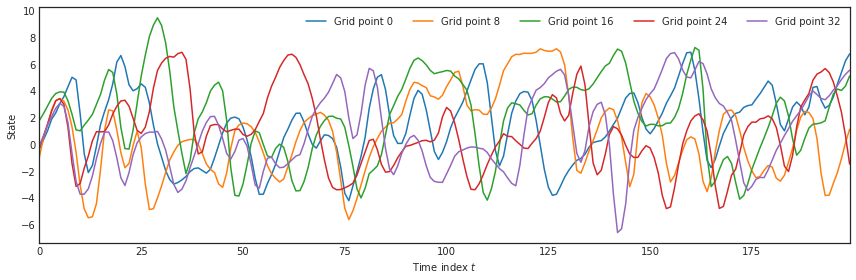

In [4]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[:, ::8])
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
ax.legend(['Grid point {0}'.format(i) for i in range(0, dim_z, 8)], ncol=5)
_ = ax.set_xlim(0, n_steps - 1)
fig.tight_layout()

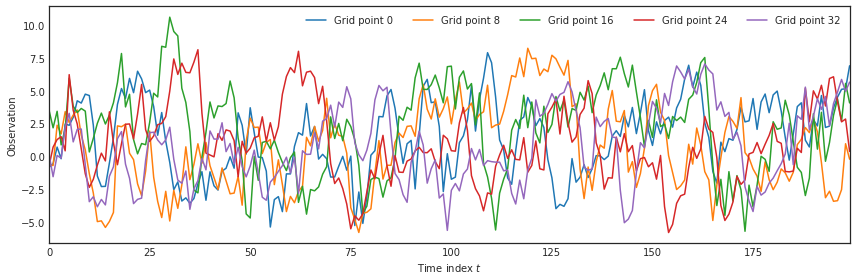

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference[:, ::8 // obs_subsample])
ax.set_xlabel('Time index $t$')
ax.set_ylabel('Observation')
ax.legend(['Grid point {0}'.format(i) for i in range(0, dim_z, 8)], ncol=5)
_ = ax.set_xlim(0, n_steps - 1)
fig.tight_layout()

## Infer state from observations

In [6]:
def plot_results(results, dim_indices, z_reference=None, 
                 plot_traces=True, plot_region=False, 
                 trace_skip=1, trace_alpha=0.25):
    n_index = len(dim_indices)
    fig, axes = plt.subplots(nrows=n_index, ncols=1, sharex=True, 
                             figsize=(12, n_index * 3))
    for i, ax in zip(dim_indices, axes):
        ax.plot(results['z_mean_seq'][:, i], 'g-', lw=1)
        if plot_region:
            ax.fill_between(
                np.arange(n_steps),
                results['z_mean_seq'][:, i] - 3 * results['z_std_seq'][:, i],
                results['z_mean_seq'][:, i] + 3 * results['z_std_seq'][:, i],
                alpha=0.25, color='g'
            )
        if plot_traces:
            ax.plot(results['z_particles_seq'][:, ::trace_skip, i], 
                    'r-', lw=0.25, alpha=trace_alpha)
        if z_reference is not None:
            ax.plot(z_reference[:, i], 'k--')
        ax.set_ylabel('State at grid point {0}'.format(i))
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

### Ensemble Kalman filter (perturbed observations)

In [7]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [8]:
%%time
results_enkf = enkf.filter(x_reference, 400, return_particles=True)

CPU times: user 25 s, sys: 324 ms, total: 25.4 s
Wall time: 6.85 s


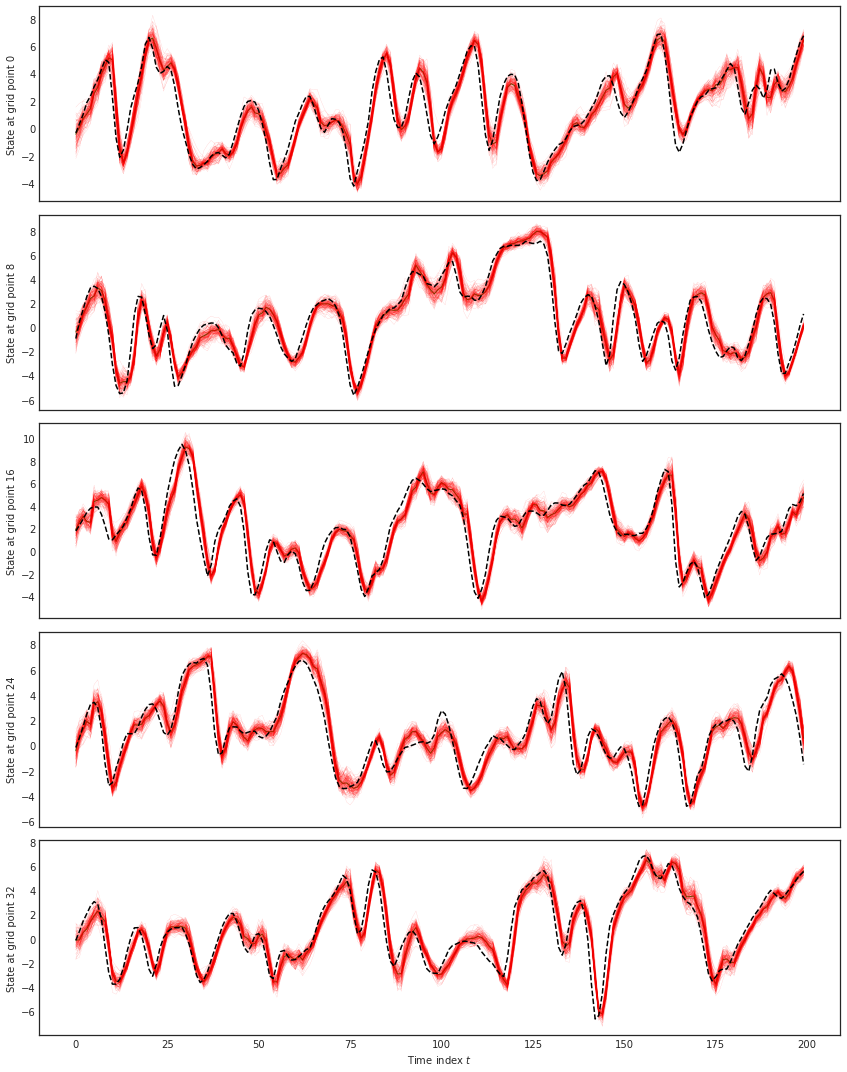

In [9]:
fig, axes = plot_results(
    results_enkf, range(0, dim_z, 8), z_reference, trace_skip=3)

### Ensemble Kalman filter (deterministic square root)

In [10]:
esrkf = da.WoodburyEnsembleSquareRootFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_func, np.eye(model.dim_x) / model.obser_noise_std, rng
)

In [11]:
%%time
results_esrkf = esrkf.filter(x_reference, 100, return_particles=True)

CPU times: user 9.22 s, sys: 232 ms, total: 9.45 s
Wall time: 3.69 s


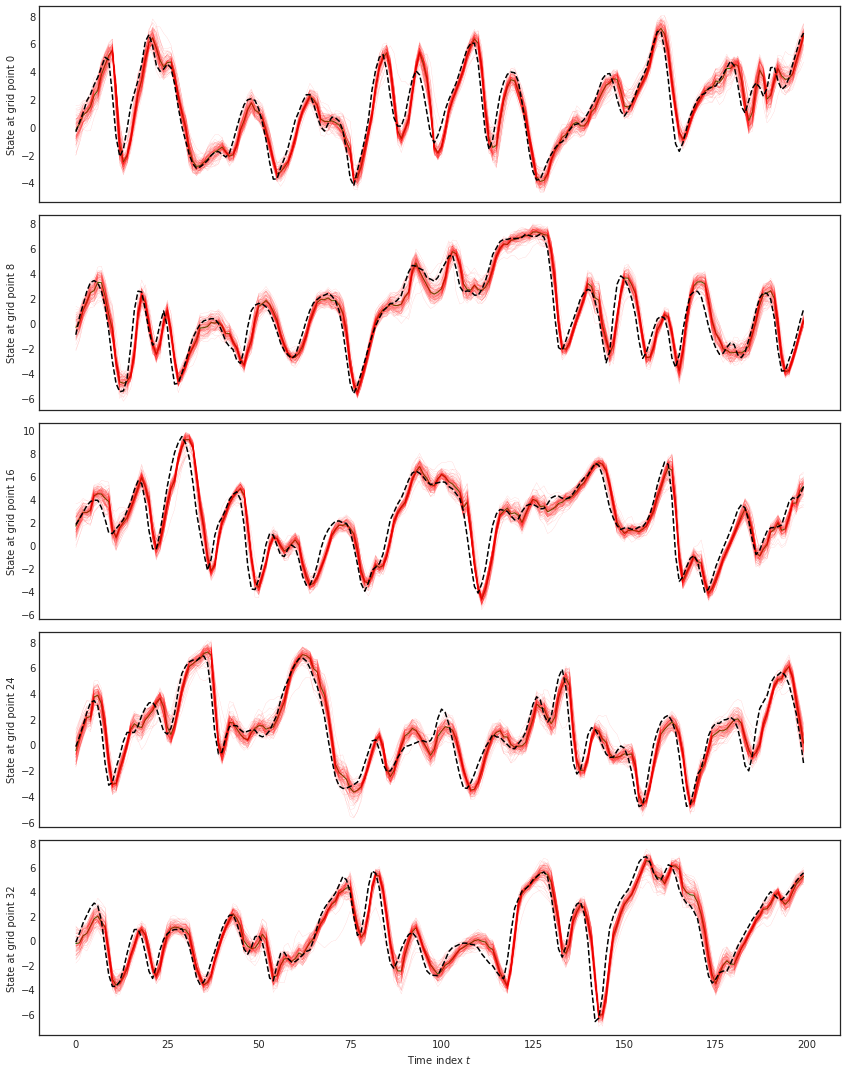

In [12]:
fig, axes = plot_results(
    results_esrkf, range(0, dim_z, 8), z_reference, trace_skip=1)

### Local ensemble transform Kalman filter

In [13]:
state_grid_coords = np.arange(model.dim_z)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = np.arange(model.dim_z)[::obs_subsample, None]
localisation_radius = 2
localisation_func = da.PeriodicLocalisationFunction(
    state_grid_coords, obser_grid_coords, state_grid_shape,
    localisation_radius, use_cache=True
)

In [14]:
letkf = da.LocalEnsembleTransformKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_z), model.dim_z, localisation_func, 1.05, rng
)

In [15]:
%%time
results_letkf = letkf.filter(x_reference, 20, return_particles=True)

CPU times: user 11.7 s, sys: 440 ms, total: 12.2 s
Wall time: 3.21 s


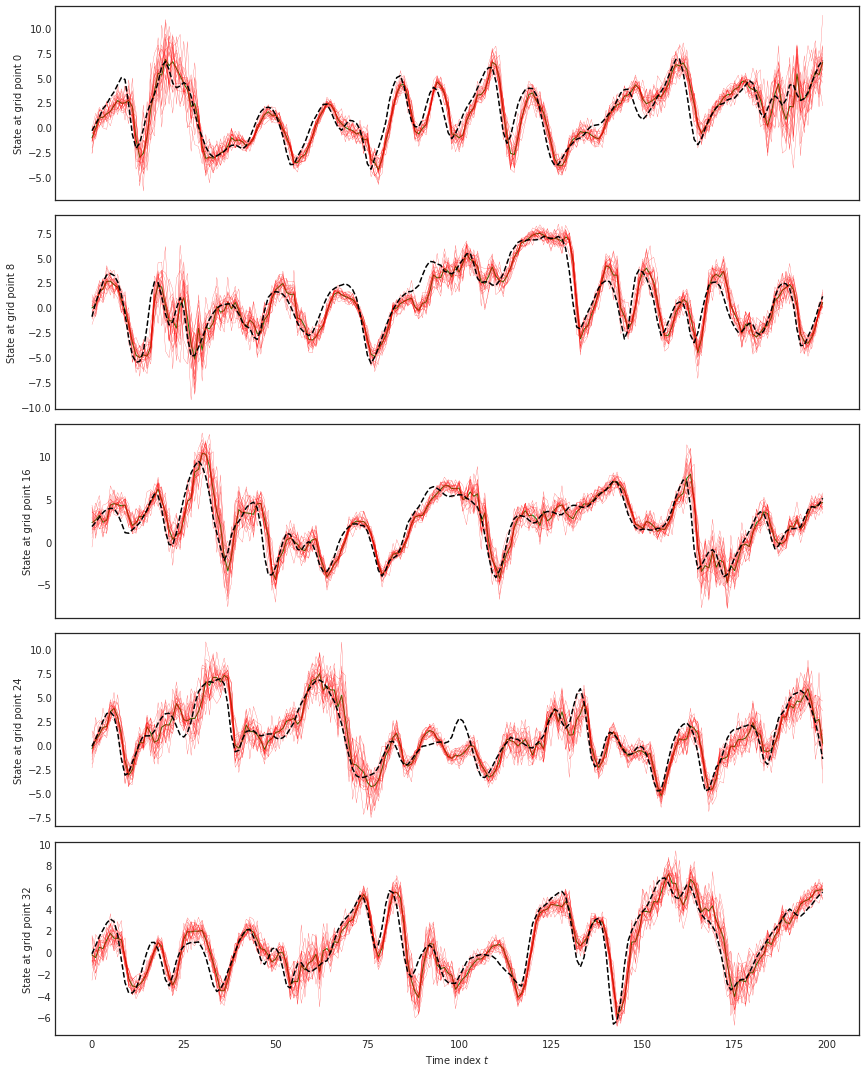

In [16]:
fig, axes = plot_results(
    results_letkf, range(0, dim_z, 8), z_reference, trace_skip=1, trace_alpha=0.75)

### Bootstrap particle filter

In [17]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [18]:
%%time
results_bspf = bspf.filter(x_reference, 1000, return_particles=True)

CPU times: user 56.7 s, sys: 476 ms, total: 57.2 s
Wall time: 15.9 s


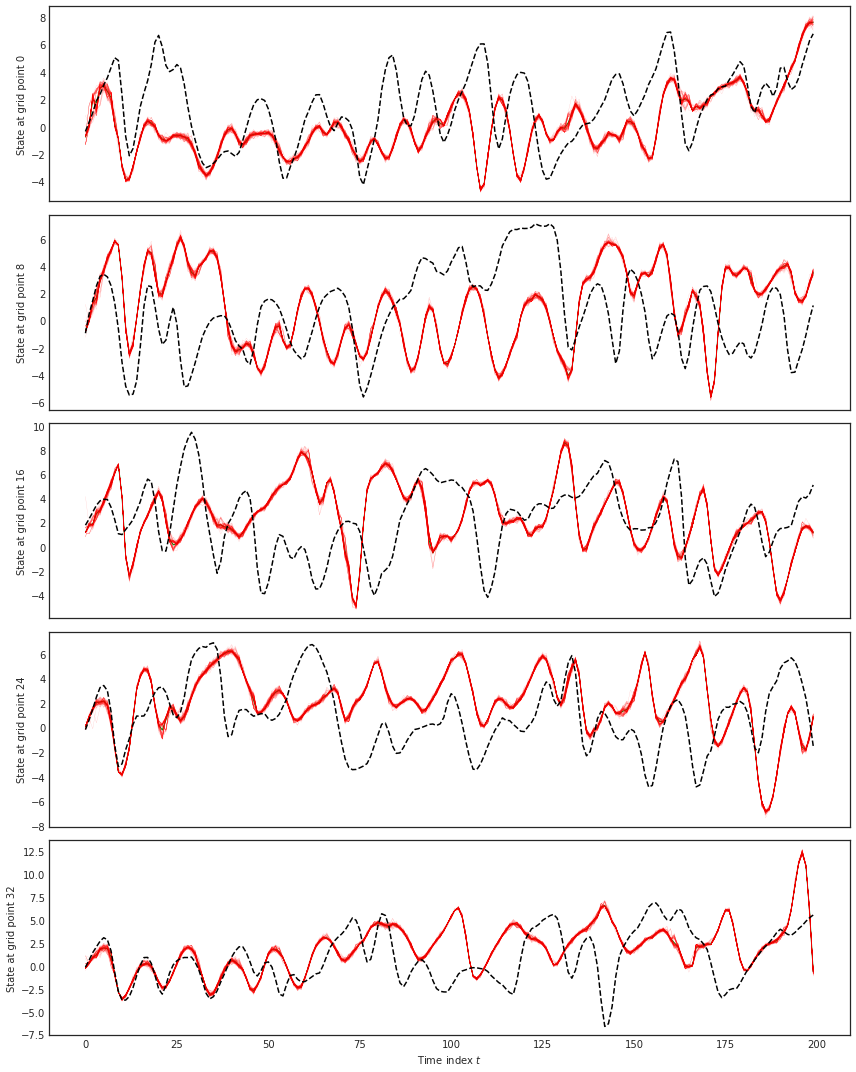

In [19]:
fig, axes = plot_results(
    results_bspf, range(0, dim_z, 8), z_reference, trace_skip=10)

### Ensemble transform particle filter

In [20]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [21]:
%%time
results_etpf = etpf.filter(x_reference, 300, return_particles=True)

CPU times: user 35.7 s, sys: 928 ms, total: 36.6 s
Wall time: 10.6 s


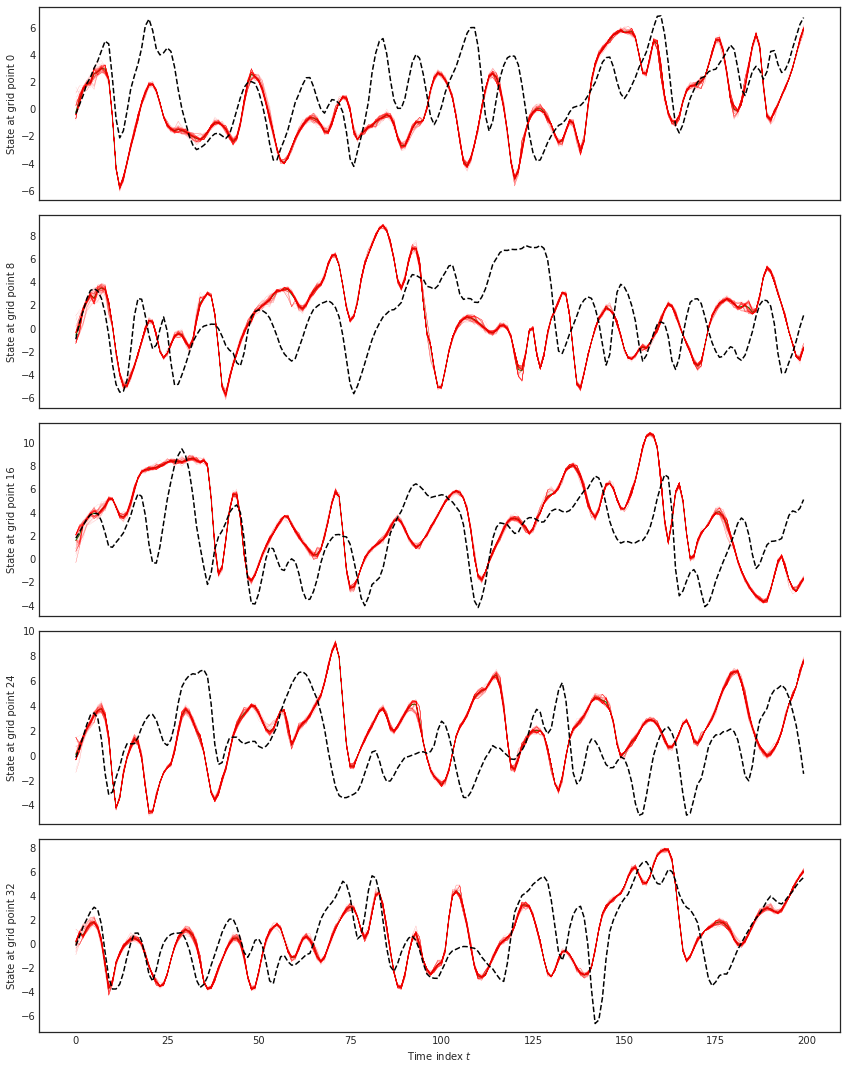

In [22]:
fig, axes = plot_results(
    results_etpf, range(0, dim_z, 8), z_reference, trace_skip=3)

## Localised ensemble transform particle filter

In [23]:
state_grid_coords = np.arange(model.dim_z)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = np.arange(model.dim_z)[::obs_subsample, None]
localisation_radius = 2
localisation_func = da.PeriodicLocalisationFunction(
    state_grid_coords, obser_grid_coords, state_grid_shape,
    localisation_radius, use_cache=True
)

In [24]:
letpf = da.LocalEnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_z), model.dim_z, localisation_func, 1.1, rng
)

In [25]:
%%time
results_letpf = letpf.filter(x_reference, 25, return_particles=True)

CPU times: user 15.2 s, sys: 592 ms, total: 15.8 s
Wall time: 4.78 s


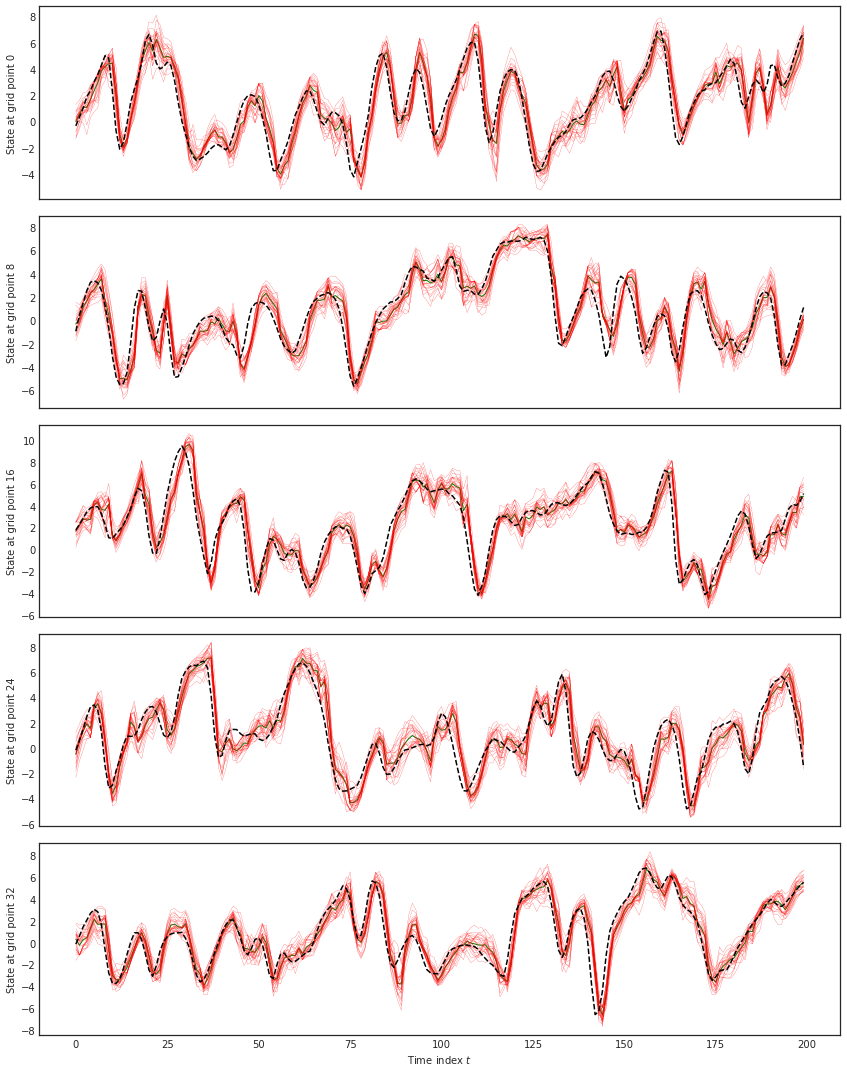

In [26]:
fig, axes = plot_results(
    results_letpf, range(0, dim_z, 8), z_reference, trace_skip=1, trace_alpha=0.75)